In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!cd drive/My\ Drive/ML/data && wget http://www.timeseriesclassification.com/Downloads/Archives/Univariate2018_ts.zip && unzip Univariate2018_ts.zip && rm Univariate2018_ts.zip

In [0]:
# !pip install sktime

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sktime.utils.load_data import load_from_tsfile_to_dataframe
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils import data
import numpy as np

In [0]:
def preprocessing(data, n , l):
  x =np.array(data['val']).reshape(n,l).astype('float32')
  scaler = MinMaxScaler()
  data_normalized = scaler.fit_transform(x)
  return data_normalized

def read_dataset(path):
  """
  Represents TS in the format of DataFrame with features: id, time, val
  - id corresponts to a particular TS
  - time - range from 0 to length of time series
  - val - series values
  (this format is necessary for tsfresh feature extraction)
  """
  raw_data, target = load_from_tsfile_to_dataframe(path)
  target = target.astype(dtype=np.int64)
  number_of_series = raw_data.shape[0]
  len_of_series = raw_data['dim_0'][0].shape[0]
  # print('Number of series = %d, length of series = %d' % (number_of_series, len_of_series))
  # print('Number of classes = %d' % len(np.unique(target)))

  data = pd.DataFrame(np.zeros((number_of_series * len_of_series, 3)), 
                      columns=['id', 'time', 'val'])
  for series_id in range(number_of_series):
    # boarders for rows in data
    low = series_id * len_of_series
    high = (series_id + 1) * len_of_series
    # fill data with values: id, time, val
    data['id'][low:high] = series_id * np.ones(len_of_series) 
    data['time'][low:high] = np.arange(0, len_of_series)
    data['val'][low:high] = raw_data['dim_0'][series_id].values
  data = preprocessing(data,number_of_series,len_of_series)
  return data, target

In [6]:
!wget  https://conda.anaconda.org/pytorch/linux-64/faiss-gpu-1.5.0-py36_cuda10.0_1.tar.bz2
!tar xvjf faiss-gpu-1.5.0-py36_cuda10.0_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl

--2020-04-06 03:44:08--  https://conda.anaconda.org/pytorch/linux-64/faiss-gpu-1.5.0-py36_cuda10.0_1.tar.bz2
Resolving conda.anaconda.org (conda.anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to conda.anaconda.org (conda.anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9cc393ec612061f033a/5c4b0434036b861dba6f46d4?response-content-disposition=attachment%3B%20filename%3D%22faiss-gpu-1.5.0-py36_cuda10.0_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-gpu-1.5.0-py36_cuda10.0_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20200406T034408Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEJH%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJIMEYCIQCjcMDSq06Qw98d9E1IFy1zEpsVjo1Wg3MODQBgORKxFAIhAKjrnugz%2FHW0M8msz3f8%2Br7bbL%2F3HMRUM7iK09AY%2F%2FZ4Kr0DCJr%2F%2F%2F%2F%2F%2F

In [0]:
import faiss

In [0]:
def visualize(X,centers,y_kmeans, d):
    print(centers.shape)
    print(centers[0].shape)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
    # plt.scatter(centers[0,:], centers[1,:], c='black', s=200, alpha=0.5)
    plt.show()



def run_kmeans(x, nmb_clusters):
    """Runs kmeans on 1 GPU.
    Args:
        x: data
        nmb_clusters (int): number of clusters
    Returns:
        list: ids of data in each cluster
    """
    n_data, d = x.shape
    # faiss implementation of k-means
    clus = faiss.Clustering(d, nmb_clusters)

    # Change faiss seed at each k-means so that the randomly picked
    # initialization centroids do not correspond to the same feature ids
    # from an epoch to another.
    clus.seed = np.random.randint(1234)

    clus.niter = 10
    clus.max_points_per_centroid = 100
    res = faiss.StandardGpuResources()
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.useFloat16 = False
    flat_config.device = 0
    index = faiss.GpuIndexFlatL2(res, d, flat_config)

    # perform the training
    clus.train(x, index)
    _, I = index.search(x, 1) #ids of the k most similar vectors for each query vector
    losses = faiss.vector_to_array(clus.obj)
    centers = faiss.vector_to_array(clus.centroids).reshape(-1, d)
    # visualize(x,centers,I,d)
    losses
    return [int(n[0]) for n in I], losses[-1]


def preprocess_features(npdata, pca=15):
    """Preprocess an array of features.
    Args:
        npdata (np.array N * ndim): features to preprocess
        pca (int): dim of output
    Returns:
        np.array of dim N * pca: data PCA-reduced, whitened and L2-normalized
    """
    _, ndim = npdata.shape
    npdata =  npdata.astype('float32')

    # Apply PCA-whitening with Faiss
    # mat = faiss.PCAMatrix (ndim, pca, eigen_power=-0.5)
    # mat.train(npdata)
    # assert mat.is_trained
    # npdata = mat.apply_py(npdata)

    # L2 normalization
    row_sums = np.linalg.norm(npdata, axis=1)
    npdata = npdata / row_sums[:, np.newaxis]

    return npdata

def arrange_clustering(ts_lists):
    """Creates a dataset from clustering, with clusters as labels.
    Args:
        ts_lists (list of list): for each cluster, the list of time series indexes
                                    belonging to this cluster
    Returns:
        pseudolabels,corresponding to initial data points
    """
    pseudolabels = []
    ts_indexes = []
    for cluster, ts in enumerate(ts_lists):
        ts_indexes.extend(ts)
        pseudolabels.extend([cluster] * len(ts))
    indexes = np.argsort(ts_indexes)
    # print('CHHHHHHEEEEECCCKKK')
    # print(pseudolabels)
    # print(indexes)
    # print(np.asarray(pseudolabels)[indexes])
    return np.asarray(pseudolabels)[indexes]

In [0]:
def cluster(data,k):
        """Performs k-means clustering.
            Args:
                x_data (np.array N * dim): data to cluster
        """
        xb = preprocess_features(data)

        # cluster the data
        I, loss = run_kmeans(xb, k) 
        ts_lists = [[] for i in range(k)]
        for i in range(len(data)):
            ts_lists[I[i]].append(i)
        return loss, ts_lists

In [0]:
# туц
class TS_CNN(nn.Module):
    def __init__(self, channels, pools, feature_size, num_classes):
        super(TS_CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(channels[0], channels[1], 7),
            nn.AvgPool1d(pools[0]),
            nn.Sigmoid(),
            nn.Conv1d(channels[1], channels[2], 7),
            nn.AvgPool1d(pools[1]),
            nn.Sigmoid()
        )
        self.cnn.apply(weights_init)
        self.classifier = nn.Linear(feature_size, num_classes)
        self.classifier.apply(weights_init)

    def forward(self, x):
        cnn_out = self.cnn(x)
        cnn_out = torch.flatten(cnn_out, start_dim=1)
        preds = self.classifier(cnn_out)
        return cnn_out, preds, F.softmax(preds)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [0]:
from sklearn.metrics import accuracy_score
# from tqdm import tqdm_notebook, tqdm
from tqdm.notebook import tqdm

In [0]:
# HOW TO USE:
# PASTE
#
# dict_ts_lists = {label: indices for label, indices in enumerate(ts_lists)}
# sampler = UnifLabelSampler(len(np_y), dict_ts_lists)

# #### Dataset with new pseudolabels ####
# train_ds = data.TensorDataset(torch.from_numpy(np_x).float(), torch.from_numpy(np_y))
# trainloader = data.DataLoader(train_ds, batch_size=32, sampler=sampler)




from torch.utils.data.sampler import Sampler

class UnifLabelSampler(Sampler):
    """Samples elements uniformely accross pseudolabels.
        Args:
            N (int): size of returned iterator.
            ts_lists: dict of key (target), value (list of data with this target)
    """

    def __init__(self, N, ts_lists):
        self.N = N
        self.ts_lists = ts_lists
        self.indexes = self.generate_indexes_epoch()

    def generate_indexes_epoch(self):
        nmb_non_empty_clusters = 0
        for i in range(len(self.ts_lists)):
            if len(self.ts_lists[i]) != 0:
                nmb_non_empty_clusters += 1

        size_per_pseudolabel = int(self.N / nmb_non_empty_clusters) + 1
        res = np.array([])

        for i in range(len(self.ts_lists)):
            # skip empty clusters
            if len(self.ts_lists[i]) == 0:
                continue
            indexes = np.random.choice(
                self.ts_lists[i],
                size_per_pseudolabel,
                replace=(len(self.ts_lists[i]) <= size_per_pseudolabel)
            )
            res = np.concatenate((res, indexes))

        np.random.shuffle(res)
        res = list(res.astype('int'))
        if len(res) >= self.N:
            return res[:self.N]
        res += res[: (self.N - len(res))]
        return res

    def __iter__(self):
        return iter(self.indexes)

    def __len__(self):
        return len(self.indexes)

In [0]:
skiplist = [
    'AllGestureWiimoteX',
    'AllGestureWiimoteY',
    'AllGestureWiimoteZ',
    'AsphaltObstacles',
    'AsphaltObstaclesCoordinates',
    'AsphaltPavementType',
    'AsphaltPavementTypeCoordinates',
    'AsphaltRegularity',
    'AsphaltRegularityCoordinates',
    'GesturePebbleZ1',
    'GesturePebbleZ2',
    'PickupGestureWiimoteZ',
    'PLAID',
    'ShakeGestureWiimoteZ',
    'MelbournePedestrian'
]

In [0]:
#fix random seeds
torch.manual_seed(31)
torch.cuda.manual_seed_all(31)
np.random.seed(31)
def deepcluster(np_x,true_y):
    np_y=np.copy(true_y)
    ################################## Loading Data #########################################
    # np_x = np.random.normal(0, 1, (500, 100))
    L= np_x.shape[1]
    np_x = np.expand_dims(np_x, axis=1)
    # np_y = np.random.randint(0, 4, (500,), dtype=np.int64)  #just random labels for the very first iteration of feature extraction
    # k = 4
    train_ds = data.TensorDataset(torch.from_numpy(np_x).float(), torch.from_numpy(np_y))
    trainloader = data.DataLoader(train_ds, batch_size=32, shuffle=True)

    ################################## Creating the model ###################################
    device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    feature_size = ((L - 7 + 1)//3 - 7 + 1)//3*12
    print(feature_size)
    net = TS_CNN(channels=[1, 6,12],
             pools=[3,3],
             feature_size=feature_size,
             num_classes=len(np.unique(np_y)))
    # net = TS_CNN(channels=[1, 128, 128, 128],
    #              pools=[2, 2, 2],
    #              feature_size=256,
    #              num_classes=4)
    criterion = CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.0001)
    net.to(device)
    k=len(np.unique(np_y))
    ################################## Traing loop ##########################################
    feature_average = None
    for epoch in range(500):
        running_loss = 0.0

        #### Extracting features for clustering ####
        all_features = []
        net.eval()
        with torch.no_grad():
            for i, batch in enumerate(trainloader, 0):
                inputs, _ = batch
                inputs = inputs.to(device)
                feats, _, _ = net(inputs)
                all_features.append(feats.detach().cpu().numpy())
        net.train()
        if feature_average is None:
            feature_average = np.vstack(all_features)
        else:
            feature_average = 0.9*feature_average + 0.1 * np.vstack(all_features)
        cluster_loss, ts_lists = cluster(feature_average,k)
        dict_ts_lists = {label: indices for label, indices in enumerate(ts_lists)}
        sampler = UnifLabelSampler(len(np_y), dict_ts_lists)
 
        if epoch % 10==0:
            np_y = arrange_clustering(ts_lists)
        # np_y = np.random.randint(0, 4, (500,), dtype=np.int64)  #change the random label generation to clustering
        # print(train_dataset.shape)
        #### Dataset with new pseudolabels ####
        train_ds = data.TensorDataset(torch.from_numpy(np_x).float(), torch.from_numpy(np_y))
        trainloader = data.DataLoader(train_ds, batch_size=32, sampler=sampler)

        #### Regular Forward/Backward passes ####
        for i, batch in enumerate(trainloader, 0):
            inputs, labels = batch
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            feats, outputs, normalized_preds = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds, preds_sm = net.forward(torch.Tensor(np_x).to(device))

    ###Freezing CNN###
    for param in net.parameters():
        param.requires_grad = False
    net.eval()
    ds = data.TensorDataset(torch.from_numpy(np_x).float(), torch.from_numpy(np_y))
    loader = data.DataLoader(ds, batch_size=32, shuffle=True)
    ### Extracting Features with the frozen CNN ###
    all_features = []
    with torch.no_grad():
        for i, batch in enumerate(loader, 0):
            inputs, _ = batch
            inputs = inputs.to(device)
            feats, _, _ = net(inputs)
            all_features.append(feats.detach().cpu().numpy())
    preextracted_features = np.vstack(all_features)
    ### New Classifier ###
    
    top_classifier  = nn.Linear(feature_size, len(np.unique(true_y)))

    top_classifier.apply(weights_init)
    top_classifier.to(device)
    ds = data.TensorDataset(torch.from_numpy(preextracted_features).float(), torch.from_numpy(true_y.astype(dtype=np.int64)))
    loader = data.DataLoader(ds, batch_size=32, shuffle=True)

    criterion = CrossEntropyLoss()
    optimizer = optim.SGD(top_classifier.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.0001)
    ### Finetuning the classifier ###
    for epoch in range(500):
        running_loss = 0.0

        for i, batch in enumerate(loader, 0):
                inputs, labels = batch
                optimizer.zero_grad()
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = top_classifier(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                # _, p, p_sm = top_classifier.forward(train_ds)
    return net, top_classifier


In [40]:
sharp = [
  "TwoPatterns",
  "ChlorineConcentration",
  "wafer",
  # "MedicalImages",
  "FaceAll",
  # "OSULeaf",
  "Adiac",
  "SwedishLeaf",
  "yoga",
  "Fish",
  "Lighting7",
  "Lighting2",
  "Trace",
  "synthetic_control",
  "FacesUCR",
  "CinC_ECG_torso",
  # "MALLAT",
  "Symbols",
  "Coffee",
  "ECG200",
  "FaceFour",
  # "OliveOil",
  "GunPoint",
  "Beef",
  "DiatomSizeReduction",
  "CBF",
  "ECGFiveDays",
  "TwoLeadECG",
  "SonyAIBORobotSurfaceII",
  "Motes",
  # "ItalyPowerDemand",
  "SonyAIBORobotSurface",
]

sharp = [i.lower() for i in sharp]
sharp

['twopatterns',
 'chlorineconcentration',
 'wafer',
 'faceall',
 'adiac',
 'swedishleaf',
 'yoga',
 'fish',
 'lighting7',
 'lighting2',
 'trace',
 'synthetic_control',
 'facesucr',
 'cinc_ecg_torso',
 'symbols',
 'coffee',
 'ecg200',
 'facefour',
 'gunpoint',
 'beef',
 'diatomsizereduction',
 'cbf',
 'ecgfivedays',
 'twoleadecg',
 'sonyaiborobotsurfaceii',
 'motes',
 'sonyaiborobotsurface']

In [0]:
res_path = 'drive/My Drive/ML/sharp_results.csv'

# results = pd.DataFrame(columns=['dataset', 'accuracy_train', 'accuracy_test'])
# results.to_csv(res_path)

# ind = len(done_models)

path_to_data = 'drive/My Drive/ML/Univariate_ts'
path_to_results='drive/My Drive/ML/predictions_new' # pls create the folder predictions first
# test_acc = []
# train_acc = []
folders= os.listdir(path_to_data)
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
folders
for e, folder in tqdm(enumerate(folders)):
    if folder in skiplist:
        continue
    if folder.lower() not in sharp:
      continue 
    path = path_to_data + '/' + folder
    print(folder)
    X_train, y_train = read_dataset(path+'/'+folder+'_TRAIN.ts')
    X_test, y_test = read_dataset(path+'/'+folder+'_TEST.ts')
    #train
    x  = X_train
    x = np.expand_dims(x, axis=1)
    y = y_train.astype(dtype=np.int64)
    conv = {label: i for i,label in enumerate(np.unique(y))}
    y_new = np.array([conv[a] for a in y]).reshape(y.shape)

    net, net2 =deepcluster(X_train,y_new)
    #train_acc
    net2.eval
    train_ds = data.TensorDataset(torch.from_numpy(x).float(), torch.from_numpy(y_new))
    train_loader = data.DataLoader(train_ds, batch_size=32, shuffle=True)
    ### Extracting Features with the frozen CNN ###
    all_features = []
    with torch.no_grad():
        for i, batch in enumerate(train_loader, 0):
            inputs, _ = batch
            inputs = inputs.to(device)
            feats, _, _ = net(inputs)
            all_features.append(feats.detach().cpu().numpy())
    preextracted_features = np.vstack(all_features)

    with torch.no_grad():
      p_sm = net2.forward(torch.from_numpy(preextracted_features).float().to(device))
    preds_labels = np.argmax(p_sm.detach().cpu().numpy(), axis=1)
    train_acc.append(accuracy_score(y_new, preds_labels))
    acc_train = accuracy_score(y_new, preds_labels)
    # pd.DataFrame({'train_preds_sm': list(preds_sm.detach().numpy()}).to_csv(path_to_results+'/train/'+folder+'.csv')
    #test
    x  = X_test
    x = np.expand_dims(x, axis=1)
    y = y_test.astype(dtype=np.int64)
    conv = {label: i for i,label in enumerate(np.unique(y))}
    y_new = np.array([conv[a] for a in y]).reshape(y.shape)
    net2.eval
    test_ds = data.TensorDataset(torch.from_numpy(x).float(), torch.from_numpy(y_new))
    test_loader = data.DataLoader(test_ds, batch_size=32, shuffle=True)
    ### Extracting Features with the frozen CNN ###
    all_features = []
    with torch.no_grad():
        for i, batch in enumerate(test_loader, 0):
            inputs, _ = batch
            inputs = inputs.to(device)
            feats, _, _ = net(inputs)
            all_features.append(feats.detach().cpu().numpy())
    preextracted_features = np.vstack(all_features)

    with torch.no_grad():
      p_sm = net2.forward(torch.from_numpy(preextracted_features).float().to(device))
    preds_labels = np.argmax(p_sm.detach().cpu().numpy(), axis=1)
    acc_test = accuracy_score(y_new, preds_labels)
    test_acc.append(accuracy_score(y_new, preds_labels))


    results = pd.read_csv(res_path)
    new = pd.DataFrame({'dataset': folder, 'accuracy_train': acc_train, 'accuracy_test': acc_test}, index =[ind])
    ind += 1
    results = pd.concat([results, new])
    results.to_csv(res_path)


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

def sharpshooter_plot(acc_train, acc_test):
    """
    Comparison of current model with 1-nn Euclidian Distance
    
    acc_train : dict, key is a dataset name, value is an accuracy on train 
    acc_test : dict, key is a dataset name, value is an accuracy on test 
    """
    
    # load 1-nn results
    nn_res = pd.read_csv('drive/My Drive/ML/1nn_results.csv')
    nn_acc_train = {data.lower().replace("_", ""): acc / 100 for data, acc in zip(nn_res['dataset'], nn_res['train_accuracy'])}
    nn_acc_test = {data.lower().replace("_", ""): acc / 100 for data, acc in zip(nn_res['dataset'], nn_res['test_accuracy'])}
    
    for i in range(len(nn_res['dataset'])):
      # if nn_res['dataset'].loc[i] == 'Lighting7':
      #   nn_res['dataset'].loc[i] = 'Lightning7'
      # elif nn_res['dataset'].loc[i] == 'Lighting2':
      #   nn_res['dataset'].loc[i] = 'Lightning2'
      nn_res['dataset'].loc[i] = nn_res['dataset'][i].lower().replace("_", "")

    set_models = set.intersection(set(nn_res['dataset']), set(acc_train.keys()))
    print(set_models)
    # Expected Accuracy Gain
    exp_gain = [acc_train[data.lower().replace("_", "")] / nn_acc_train[data.lower().replace("_", "")] for data in set_models]
    
    # Actual Accuracy Gain
    act_gain = [acc_test[data.lower().replace("_", "")] / nn_acc_test[data.lower().replace("_", "")] for data in set_models]
    
    fig = plt.figure(figsize=(8, 8))
    plt.rcParams.update({'font.size': 14})
    plt.fill_between([1, max(exp_gain)], [1, 1], [max(act_gain), max(act_gain)], alpha=0.3)
    plt.fill_between([min(exp_gain), 1], [1, 1], [min(act_gain), min(act_gain)], alpha=0.3)    
    plt.plot(exp_gain, [1] * len(exp_gain)) # line y = 1
    plt.plot([1] * len(act_gain), act_gain) # line x = 1
    plt.scatter(exp_gain, act_gain, c='black')
    plt.text((max(exp_gain) + 1) / 2, (max(act_gain) + 1) / 2, 'TP', fontsize=18)
    plt.text((max(exp_gain) + 1) / 2, (min(act_gain) + 1) / 2, 'FP', fontsize=18)
    plt.text((min(exp_gain) + 1) / 2, (max(act_gain) + 1) / 2, 'FN', fontsize=18)
    plt.text((min(exp_gain) + 1) / 2, (min(act_gain) + 1) / 2, 'TN', fontsize=18)
    plt.title('Texas Sharpshooter Plot')
    plt.xlabel('Expected Accuracy Gain')
    plt.ylabel('Actual Accuracy Gain')
    
    fig.savefig('drive/My Drive/ML/sharpshooter_plot_Freezing.png')


In [0]:
res_path = 'drive/My Drive/ML/sharp_results.csv'

results = pd.read_csv(res_path)
acc_train = {d.lower(): a for d, a in zip(results['dataset'], results['accuracy_train'])}
acc_test = {d.lower(): a for d, a in zip(results['dataset'], results['accuracy_test'])}

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'twoleadecg', 'twopatterns', 'osuleaf', 'fish', 'cbf', 'beef', 'adiac', 'coffee', 'diatomsizereduction', 'facefour', 'faceall', 'ecgfivedays', 'swedishleaf', 'wafer', 'chlorineconcentration', 'trace', 'symbols', 'facesucr', 'yoga', 'ecg200'}


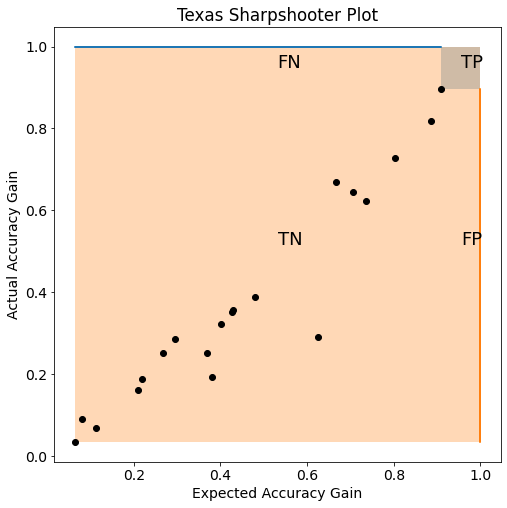

In [47]:
sharpshooter_plot(acc_train, acc_test)